In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [3]:
def create_matrix(n):
  A = np.zeros((n,n))
  for i in range(0,n):
    for j in range(0,n):
      if i == j:
        A[i,j] = -i -1
      if j == i + 1:
        A[i,j] = 20
  return A

In [4]:
def solve_tridiag_system(A, b):
  #Thomas Algorithm
  n = len(b)
  if A.shape[1] != n:
    return -1
  x = np.zeros(n)

  _c = np.zeros(n)
  _b = np.zeros(n)

  _c[0] = A[0,1]/ A[0,0]
  _b[0] = b[0]/ A[0,0]

  for i in range(1,n):
    if i < n - 1:
      _c[i] = A[i,i + 1]/( A[i,i] - A[i,i - 1]*_c[i - 1])
    else:
      _c[i] = 0

    _b[i] = (b[i] - A[i,i - 1]*_b[i - 1])/( A[i,i] - A[i,i - 1]*_c[i - 1])


  #Now we can solve the system
  x[n - 1] = _b[n - 1]

  for i in range(n - 2, -1, -1):
    x[i] = _b[i] - _c[i]*x[i + 1]

  return x


In [14]:
def plot_component(Y,Y_ex,J,N,dt,T):
  Y_J = []
  Y_ex_J = []
  Err = []
  for i in range(0, len(Y)):
    Y_J.append(Y[i][J])
    Y_ex_J.append(Y_ex[i][J])

  plt.plot(T,Y_ex_J,'k')
  plt.plot(T,Y_J,'r-.')
  plt.legend(["Exact solution" , "Computed solution "])

In [6]:
def compute_Error(Y,Y_ex,J,N,dt,T):
  Y_J = []
  Y_ex_J = []
  Err = []
  for i in range(0, len(Y)):
    Y_J.append(Y[i][J])
    Y_ex_J.append(Y_ex[i][J])
    Err.append((Y[i][J] - Y_ex[i][J])**2)

  err = 0.0
  #Trapezoidal rule to compute the integral
  for i in range(1, len(Err)):
    err+= dt*(Err[i] + Err[i - 1])/2

  err = np.sqrt(err)
  return err

In [7]:
def exact_solution(A,T,T0,Y_0):
  Y_ex = []
  for t in T:
    exp_A = expm(A*(t - T0))
    Y_ex.append(np.dot(exp_A,Y_0))
  return Y_ex

Solve the problem dy/dt = A*y with A tridiagonal matrix of size 20x20, the ith element of the main diagonal of A is equal to i and the and the element of the subdiagonal are equal to 20.


In [23]:
#Size of the matrix
n = 20
#Initial and final time
Tf = 20
T0 = 0
#Discretization steps
N = 1000
T = np.linspace(T0,Tf,N)
dt = (Tf - T0)/N
#Initial condition
Y_0 = np.ones(n)
#Initialize the matrix of the problem
A = create_matrix(n)
#Exact Solution
Y_ex = exact_solution(A,T,T0,Y_0)

In [10]:
def forwardEuler(A, Y_0, T, T0):
  #Forward Euler method implementation
  Y = []
  Y_n = Y_0
  Y.append(Y_n)

  for i in range(1,len(T)):
    dt = T[i] - T[i - 1]
    Y_n = Y_n + dt*np.dot(A,Y_n)
    Y.append(Y_n)

  return Y



In [15]:
Y_fe = forwardEuler(A, Y_0, T, T0)
plot_component(Y_fe,Y_ex,1,N,dt,T)

In [16]:
def backwardEuler(A, Y_0, T, T0):
  #Backward Euler method implementation
  Y = []
  Y_n = Y_0
  Y.append(Y_n)

  for i in range(1, len(T)):
    dt = T[i] - T[i - 1]
    B = np.identity(n) - dt*A
    Y_n = solve_tridiag_system(B, Y_n)
    Y.append(Y_n)

  return Y

In [17]:
Y_be = backwardEuler(A, Y_0, T, T0)
plot_component(Y_be,Y_ex,1,N,dt,T)

In [18]:
def CrankNicolson(A, Y_0, T, T0):
  #Crank Nicolson method implementation
  Y = []
  Y_n = Y_0
  Y.append(Y_n)

  for i in range(1,len(T)):
    dt = T[i] - T[i - 1]
    B = np.identity(A.shape[0]) - (dt/2)*A
    b = Y_n + (dt/2)*np.dot(A,Y_n)
    Y_n = solve_tridiag_system(B, b)
    Y.append(Y_n)

  return Y

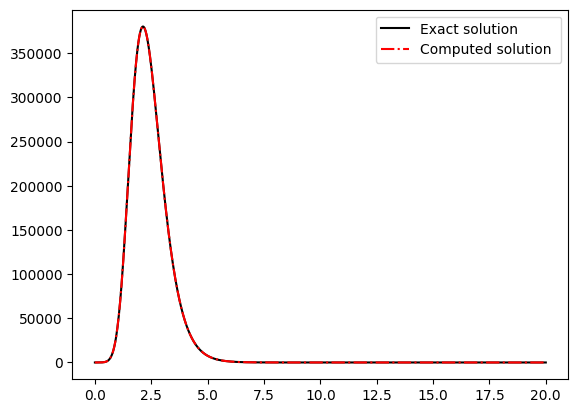

In [24]:
Y_cn = CrankNicolson(A, Y_0, T, T0)
plot_component(Y_cn,Y_ex,1,N,dt,T)

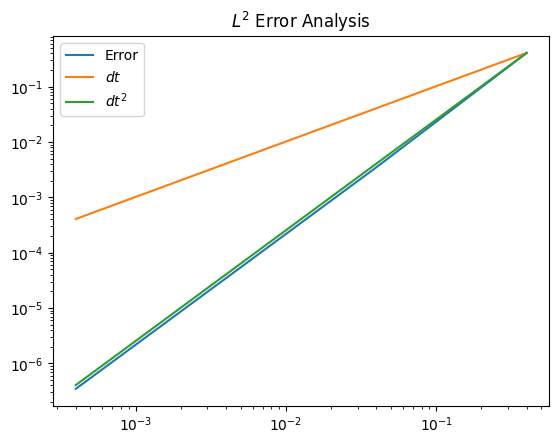

In [21]:
#Error analysis for one component
NN = [50, 500, 5000, 50000]

n = 3
Tf = 20
T0 = 0
Y_0 = np.ones(n)
A = create_matrix(n)
component = 1
err = []
DT = []

for N in NN:
  T = np.linspace(T0,Tf,N)
  dt = (Tf - T0)/N
  Y_ex = exact_solution(A,T,T0,Y_0)
  Y_cn = CrankNicolson(A, Y_0, T, T0)
  err.append(compute_Error(Y_cn,Y_ex,component,N,dt,T))
  DT.append(dt)

DT = np.array(DT)
plt.title("$L^2$ Error Analysis")
plt.loglog(DT,err)
plt.loglog(DT,DT*(err[0]/DT[0]))
plt.loglog(DT,(DT**2)*(err[0]/(DT[0]**2)))
plt.legend(["Error", "$dt$", "$dt^2$"])